<a href="https://colab.research.google.com/github/abdulwadood4/abdulwadood4.github.io/blob/main/Predictive_Maintenance_%E2%80%93_Remaining_Useful_Life_(RUL)_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup and imports
!pip install -q xgboost shap

import os, random, zipfile, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib, json

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Download and unzip C-MAPSS dataset (FD001)
!wget -q https://data.nasa.gov/docs/legacy/CMAPSSData.zip -O CMAPSSData.zip
!unzip -q -o CMAPSSData.zip -d CMAPSSData

print("Files in CMAPSSData:", os.listdir("CMAPSSData"))


Files in CMAPSSData: ['readme.txt', 'RUL_FD004.txt', 'test_FD001.txt', 'Damage Propagation Modeling.pdf', 'RUL_FD001.txt', 'train_FD004.txt', 'RUL_FD002.txt', 'test_FD002.txt', 'test_FD004.txt', 'train_FD003.txt', 'train_FD002.txt', 'RUL_FD003.txt', 'train_FD001.txt', 'test_FD003.txt']


In [3]:
# Load C-MAPSS FD001 dataset
def load_cmapss(file_path):
    cols = ['unit', 'cycle'] + [f'op{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]
    return pd.read_csv(file_path, sep='\s+', header=None, names=cols)


train = load_cmapss('CMAPSSData/train_FD001.txt')
test  = load_cmapss('CMAPSSData/test_FD001.txt')
rul   = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])


print("train shape:", train.shape, "test shape:", test.shape, "rul shape:", rul.shape)
train.head()


train shape: (20631, 26) test shape: (13096, 26) rul shape: (100, 1)


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1130897541.py:4: SyntaxWarning: invalid escape sequence '\s'
  return pd.read_csv(file_path, sep='\s+', header=None, names=cols)
/tmp/ipython-input-1130897541.py:9: SyntaxWarning: invalid escape sequence '\s'
  rul   = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])


,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
# Compute Remaining Useful Life (RUL) for training and prepare test set ground truth
max_cycle = train.groupby('unit')['cycle'].max().reset_index().rename(columns={'cycle':'max_cycle'})
train = train.merge(max_cycle, on='unit', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop(columns=['max_cycle'], inplace=True)

# Apply piecewise cap for RUL
MAX_RUL = 130
train['RUL_pw'] = train['RUL'].clip(upper=MAX_RUL)

# Prepare last-cycle rows for test set with true RUL
test_max = test.groupby('unit')['cycle'].max().reset_index().rename(columns={'cycle':'max_cycle'})
test_last = test.merge(test_max, on='unit', how='left')
test_last = test_last[test_last['cycle']==test_last['max_cycle']].copy().reset_index(drop=True)
test_last['RUL_true'] = rul['RUL']

print("train shape:", train.shape, "test last rows:", test_last.shape)


train shape: (20631, 28) test last rows: (100, 28)


In [5]:
# Quick EDA & sensor selection (drop near-constant sensors)
sensor_cols = [c for c in train.columns if c.startswith('sensor')]
sds = train[sensor_cols].std().sort_values()
print("Sensor stds (lowest 8):\n", sds.head(8))
low_var = sds[sds < 1e-3].index.tolist()
print("Low-variance sensors (will drop if present):", low_var)
use_sensors = [s for s in sensor_cols if s not in low_var]
print("Using sensors:", use_sensors)


Sensor stds (lowest 8):
 sensor19    0.000000e+00
sensor18    0.000000e+00
sensor16    1.556432e-14
sensor10    4.660829e-13
sensor5     3.394700e-12
sensor1     6.537152e-11
sensor6     1.388985e-03
sensor15    3.750504e-02
dtype: float64
Low-variance sensors (will drop if present): ['sensor19', 'sensor18', 'sensor16', 'sensor10', 'sensor5', 'sensor1']
Using sensors: ['sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21']


In [6]:
# Create rolling aggregate features for tree-based models
def add_rolling_features(df, sensors, window=30):
    df = df.sort_values(['unit','cycle']).copy()
    agg_list = ['mean','std','min','max']
    rolled = (df.groupby('unit')[sensors]
              .rolling(window, min_periods=1)
              .agg(agg_list)
              .reset_index(level=0, drop=True))
    rolled.columns = [f"{sensor}_{stat}" for sensor, stat in rolled.columns]
    df = pd.concat([df.reset_index(drop=True), rolled.reset_index(drop=True)], axis=1)
    df['cycle_norm'] = df['cycle'] / df.groupby('unit')['cycle'].transform('max')
    return df

WINDOW = 30
train_feat = add_rolling_features(train, use_sensors, window=WINDOW)
test_feat  = add_rolling_features(test, use_sensors, window=WINDOW)

print("train_feat shape:", train_feat.shape)


train_feat shape: (20631, 89)


In [7]:
# Train / validation split (by engine units)
units = train_feat['unit'].unique()
train_units, val_units = train_test_split(units, test_size=0.2, random_state=SEED)
tr = train_feat[train_feat['unit'].isin(train_units)].copy()
val = train_feat[train_feat['unit'].isin(val_units)].copy()
print("Units split — train:", len(train_units), "val:", len(val_units))


Units split — train: 80 val: 20


In [8]:
# Prepare features & scaler
agg_cols = [c for c in tr.columns if any(c.endswith(s) for s in ['mean','std','min','max'])]
meta_cols = ['cycle','cycle_norm','op1','op2','op3']
feature_cols = agg_cols + meta_cols

scaler = StandardScaler()
X_train = scaler.fit_transform(tr[feature_cols])
y_train = tr['RUL_pw'].values

X_val = scaler.transform(val[feature_cols])
y_val = val['RUL_pw'].values

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)


X_train shape: (16561, 65) y_train shape: (16561,)


In [9]:
# Train and evaluate baseline Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)

# Validation prediction
yhat_val_rf = rf.predict(X_val)

# Compute RMSE and MAE (version-safe)
mse_rf = mean_squared_error(y_val, yhat_val_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_val, yhat_val_rf)

print("RF val RMSE:", round(rmse_rf, 4), "MAE:", round(mae_rf, 4))

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(12)
print("\nTop feature importances:\n", importances)



RF val RMSE: 1.869 MAE: 0.9905

Top feature importances:
 cycle_norm      0.942168
cycle           0.055029
sensor15_min    0.000139
sensor9_std     0.000135
sensor9_max     0.000125
sensor21_min    0.000117
sensor2_max     0.000107
sensor4_min     0.000097
sensor2_std     0.000088
sensor7_std     0.000083
sensor15_std    0.000077
sensor7_mean    0.000076
dtype: float64


In [10]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=SEED, n_jobs=-1)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

yhat_val_xgb = xgb_model.predict(X_val)
print("XGB RMSE:", round(np.sqrt(mean_squared_error(y_val, yhat_val_xgb)),4))

XGB RMSE: 2.241


In [11]:
# PHM asymmetric scoring function (Saxena-style)
def phm_score(y_true, y_pred):
    d = y_pred - y_true
    s = np.where(d <= 0, np.exp(-d / 13.0) - 1.0, np.exp(d / 10.0) - 1.0)
    return np.sum(s)

print("RF PHM score:", round(phm_score(y_val, yhat_val_rf),4))
print("XGB PHM score:", round(phm_score(y_val, yhat_val_xgb),4))


RF PHM score: 443.7343
XGB PHM score: 574.0438


In [12]:
# Sequence creation for LSTM
def create_sequences(df, sensors, seq_len=30, include_meta=['op1','op2','op3','cycle_norm']):
    sequences, labels = [], []
    for unit, g in df.groupby('unit'):
        g = g.sort_values('cycle')
        data = g[sensors + include_meta].values
        lab = g['RUL_pw'].values
        for i in range(len(g)):
            if i+1 >= seq_len:
                sequences.append(data[i+1-seq_len:i+1])
                labels.append(lab[i])
    return np.array(sequences), np.array(labels)

SEQ_LEN = 30
lstm_sensors = use_sensors  # sensors selected earlier
X_tr_seq, y_tr_seq = create_sequences(tr, lstm_sensors, seq_len=SEQ_LEN)
X_val_seq, y_val_seq = create_sequences(val, lstm_sensors, seq_len=SEQ_LEN)
print("LSTM shapes:", X_tr_seq.shape, y_tr_seq.shape, X_val_seq.shape, y_val_seq.shape)


LSTM shapes: (14241, 30, 19) (14241,) (3490, 30, 19) (3490,)


In [13]:
# Build & train LSTM
n_features = X_tr_seq.shape[2]
model = models.Sequential([
    layers.Masking(mask_value=0., input_shape=(SEQ_LEN, n_features)),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_tr_seq, y_tr_seq, validation_data=(X_val_seq, y_val_seq),
                    epochs=80, batch_size=64, callbacks=[es], verbose=2)
yhat_val_lstm = model.predict(X_val_seq).reshape(-1)
print("LSTM val RMSE:", round(np.sqrt(mean_squared_error(y_val_seq, yhat_val_lstm)),4))
print("LSTM PHM score:", round(phm_score(y_val_seq, yhat_val_lstm),4))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
223/223 - 7s - 33ms/step - loss: 4072.6472 - root_mean_squared_error: 63.8173 - val_loss: 1871.9706 - val_root_mean_squared_error: 43.2663
Epoch 2/80
223/223 - 2s - 11ms/step - loss: 1905.3241 - root_mean_squared_error: 43.6500 - val_loss: 1871.8427 - val_root_mean_squared_error: 43.2648
Epoch 3/80
223/223 - 2s - 10ms/step - loss: 1905.0975 - root_mean_squared_error: 43.6474 - val_loss: 1872.0758 - val_root_mean_squared_error: 43.2675
Epoch 4/80
223/223 - 2s - 8ms/step - loss: 1911.4062 - root_mean_squared_error: 43.7196 - val_loss: 1871.8735 - val_root_mean_squared_error: 43.2652
Epoch 5/80
223/223 - 2s - 8ms/step - loss: 1909.0146 - root_mean_squared_error: 43.6923 - val_loss: 1871.9535 - val_root_mean_squared_error: 43.2661
Epoch 6/80
223/223 - 2s - 8ms/step - loss: 1909.4843 - root_mean_squared_error: 43.6976 - val_loss: 1871.7733 - val_root_mean_squared_error: 43.2640
Epoch 7/80
223/223 - 2s - 8ms/step - loss: 1905.4618 - root_mean_squared_error: 43.6516 - val_loss: 187

In [14]:
# Predict RUL on test set for RF, XGBoost, and LSTM
# RF/XGB: use last row per unit
test_feat_last = test_feat.sort_values(['unit','cycle']).groupby('unit').tail(1).reset_index(drop=True)
X_test_last = scaler.transform(test_feat_last[feature_cols])
pred_rf_test = rf.predict(X_test_last)
pred_xgb_test = xgb_model.predict(X_test_last)

# LSTM: create sequences for test set and take last sequence per unit
def create_sequences_test(df, sensors, seq_len=30, include_meta=['op1','op2','op3','cycle_norm']):
    sequences = []
    for unit, g in df.groupby('unit'):
        g = g.sort_values('cycle')
        data = g[sensors + include_meta].values
        for i in range(len(g)):
            if i+1 >= seq_len:
                sequences.append(data[i+1-seq_len:i+1])
    return np.array(sequences)

X_test_seq = create_sequences_test(test_feat, lstm_sensors, seq_len=SEQ_LEN)
preds_lstm_seq = model.predict(X_test_seq).reshape(-1)

# Map LSTM predictions to last sequence per unit
units = test_feat['unit'].unique()
preds_lstm_last = []
seq_idx = 0
for u in units:
    unit_len = len(test_feat[test_feat['unit']==u])
    num_sequences = max(0, unit_len - SEQ_LEN + 1)
    if num_sequences > 0:
        last_seq_index_in_unit = num_sequences - 1
        global_last_seq_index = seq_idx + last_seq_index_in_unit
        preds_lstm_last.append(preds_lstm_seq[global_last_seq_index])
        seq_idx += num_sequences
preds_lstm_last = np.array(preds_lstm_last)

# Display shapes
print("Predictions shapes (units):", pred_rf_test.shape, pred_xgb_test.shape, preds_lstm_last.shape)

# Evaluate test set predictions
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

print("Test RF RMSE:", round(calculate_rmse(test_last['RUL_true'].values, pred_rf_test),4))
print("Test RF PHM:", round(phm_score(test_last['RUL_true'].values, pred_rf_test),4))
print("Test XGB RMSE:", round(calculate_rmse(test_last['RUL_true'].values, pred_xgb_test),4))
print("Test XGB PHM:", round(phm_score(test_last['RUL_true'].values, pred_xgb_test),4))
print("Test LSTM RMSE:", round(calculate_rmse(test_last['RUL_true'].values, preds_lstm_last),4))
print("Test LSTM PHM:", round(phm_score(test_last['RUL_true'].values, preds_lstm_last),4))


319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Predictions shapes (units): (100,) (100,) (100,)
Test RF RMSE: 86.1983
Test RF PHM: 559017.6914
Test XGB RMSE: 85.8389
Test XGB PHM: 546900.503
Test LSTM RMSE: 42.0082
Test LSTM PHM: 20654.7474


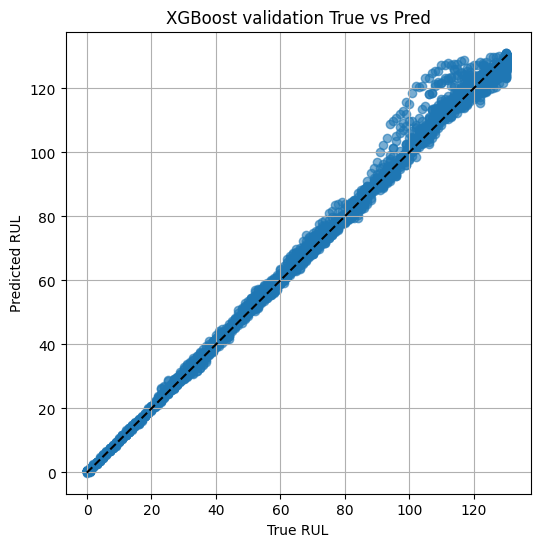

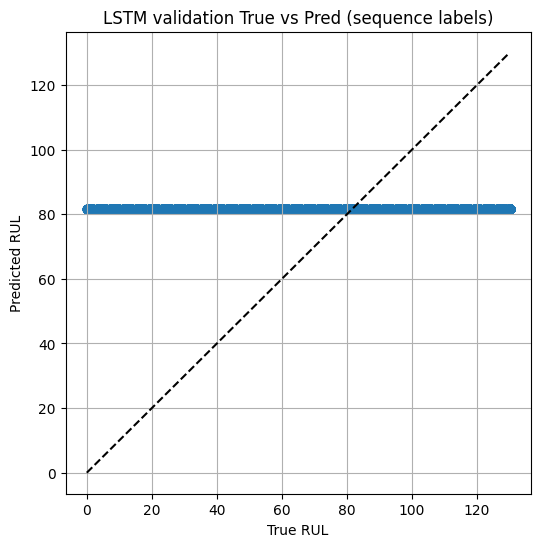

In [15]:
# Visualization helpers & example plots
def plot_true_vs_pred(y_true, y_pred, title="True vs Pred"):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'k--')
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_true_vs_pred(y_val, yhat_val_xgb, title="XGBoost validation True vs Pred")
plot_true_vs_pred(y_val_seq, yhat_val_lstm, title="LSTM validation True vs Pred (sequence labels)")


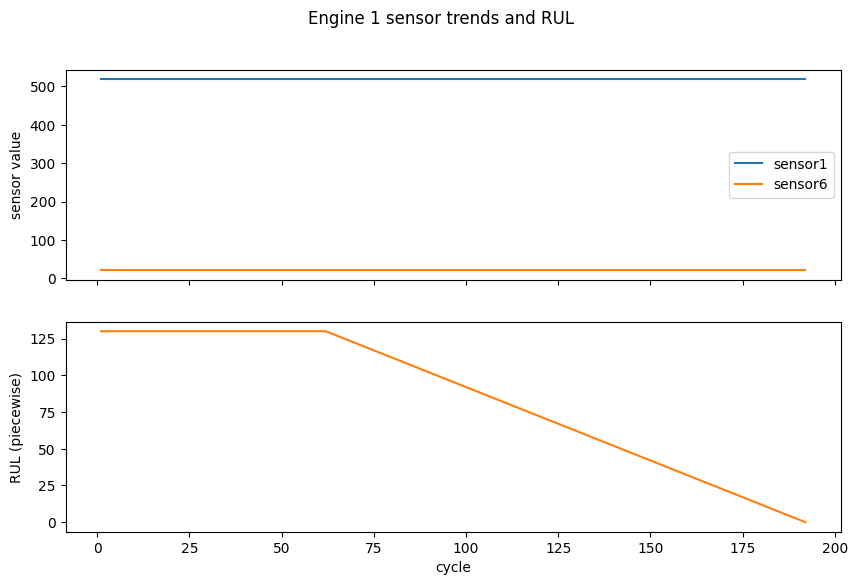

In [16]:
# Per-engine RUL and sensor trend plotting example
def plot_engine_trends(unit_id):
    df_unit = train[train['unit']==unit_id].sort_values('cycle')
    fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
    axes[0].plot(df_unit['cycle'], df_unit['sensor1'], label='sensor1')
    axes[0].plot(df_unit['cycle'], df_unit['sensor6'], label='sensor6')
    axes[0].legend()
    axes[0].set_ylabel('sensor value')
    axes[1].plot(df_unit['cycle'], df_unit['RUL_pw'], color='tab:orange')
    axes[1].set_ylabel('RUL (piecewise)')
    axes[1].set_xlabel('cycle')
    plt.suptitle(f'Engine {unit_id} sensor trends and RUL')
    plt.show()

plot_engine_trends(unit_id=1)


In [ ]:
# Downloadable Artifacts
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf_fd001.pkl")
joblib.dump(xgb_model, "models/xgb_fd001.pkl")
joblib.dump(scaler, "models/scaler_fd001.pkl")
model.save("models/lstm_fd001.h5")
print("Saved models to /models")


Saved models to /models


In [ ]:
# README
repo_structure = {
 "name":"cmapss-rul",
 "notebooks":["01_download_and_eda.ipynb","02_features_rf_xgb.ipynb","03_lstm.ipynb"],
 "src":["data.py","features.py","models.py","metrics.py"],
 "models":["rf_fd001.pkl","xgb_fd001.pkl","lstm_fd001.h5"]
}
with open("README_SAMPLE.md","w") as f:
    f.write("# Predictive Maintenance — NASA C-MAPSS FD001\n\n")
    f.write("This repo contains a guided pipeline for Remaining Useful Life (RUL) prediction on the NASA C-MAPSS FD001 dataset. Use the notebooks in `notebooks/` to reproduce experiments.\n\n")
    f.write("## Quick run (Colab)\n1. Open the notebook in Colab.\n2. Run cells top-to-bottom. Use GPU for LSTM.\n\n")
    f.write("## Models saved in `models/`.\n")
print("README_SAMPLE.md generated.")
!ls -la


README_SAMPLE.md generated.
total 12164
drwxr-xr-x 1 root root     4096 Oct 14 13:23 .
drwxr-xr-x 1 root root     4096 Oct 14 12:59 ..
drwxr-xr-x 2 root root     4096 Oct 14 13:01 CMAPSSData
-rw-r--r-- 1 root root 12425978 Mar 26  2025 CMAPSSData.zip
drwxr-xr-x 4 root root     4096 Oct 10 13:36 .config
drwxr-xr-x 2 root root     4096 Oct 14 13:23 models
-rw-r--r-- 1 root root      354 Oct 14 13:23 README_SAMPLE.md
drwxr-xr-x 1 root root     4096 Oct 10 13:36 sample_data


In [ ]:
import os
from google.colab import files

# 1️⃣ Show current working directory
print("Current working directory:", os.getcwd())

# 2️⃣ List model files (if folder exists)
if os.path.exists("models"):
    print("\nFiles in 'models' folder:")
    for f in os.listdir("models"):
        print(" -", f)
else:
    print("\n❌ 'models' folder not found. Make sure you ran the training cell first.")

# 3️⃣ Download all saved model artifacts
model_files = [
    "models/rf_fd001.pkl",
    "models/xgb_fd001.pkl",
    "models/scaler_fd001.pkl",
    "models/lstm_fd001.h5"
]

for file_path in model_files:
    if os.path.exists(file_path):
        print(f"\n⬇️ Downloading {file_path} ...")
        files.download(file_path)
    else:
        print(f"\n⚠️ File not found: {file_path}")


Current working directory: /content

Files in 'models' folder:
 - rf_fd001.pkl
 - scaler_fd001.pkl
 - xgb_fd001.pkl
 - lstm_fd001.h5

⬇️ Downloading models/rf_fd001.pkl ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ Downloading models/xgb_fd001.pkl ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ Downloading models/scaler_fd001.pkl ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ Downloading models/lstm_fd001.h5 ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>